#  Circularity Interventions in monetary tables

Objectives
- Learn how to create scenarios in IO 
- Assess the impacts of circularity interventions
- Conduct a novel analysis 

You can download exiobase through this link https://zenodo.org/record/5589597
 
We will work with: IOT_2019_ixi.zip

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Import the data

In [2]:
A = pd.read_csv('../data/monetary/IOT_2019_ixi/A.txt', sep='\t',
                index_col=[0, 1], header=[0, 1])  # A matrix
Y = pd.read_csv('../data/monetary/IOT_2019_ixi/Y.txt', sep='\t',
                index_col=[0, 1], header=[0, 1])  # Y matrix

In [3]:
F = pd.read_csv('../data/monetary/IOT_2019_ixi/satellite/F.txt', sep='\t',
                index_col=[0], header=[0, 1])  # satellites matrix
F_hh = pd.read_csv('../data/monetary/IOT_2019_ixi/satellite/F_Y.txt', sep='\t',
                index_col=[0], header=[0, 1])  # satellites for FD matrix

M = pd.read_csv('../data/monetary/IOT_2019_ixi/impacts/F.txt', sep='\t',
                index_col=[0], header=[0, 1])  # impacts matrix
M_hh = pd.read_csv('../data/monetary/IOT_2019_ixi/impacts/F_Y.txt', sep='\t',
                index_col=[0], header=[0, 1])  # impacts for FD matrix

## Step 2: Calculate the MR EEIO variables

### 2.1 First we calculate the Leontief inverse

In [4]:
I = np.identity(A.shape[0]) # A.shape[0] is the total number of columns in the A matrix
L = np.linalg.inv(I-A)

### 2.2 We calculate our product output x

In [5]:
x = L@Y.sum(axis=1)

# A check to see whether the resulting x is right
print(x.shape)
print(x)

(7987,)
[    0.           378.27210222   894.02517191 ... 31620.40267628
  7096.15298551     0.        ]


### 2.3  The diagonal inverse of the product total output

In [6]:
# we make a copy of our product output vector
x_ = x.copy() 

# we divide 1 by the values that are non-0
x_[x_!=0] = 1/x_[x_!=0]

# We diagolize the resulting vector
inv_diag_x = np.diag(x_)

### 2.4 Calculate the intensities

In [7]:
f = F @ inv_diag_x # intensities of the environmental extensions
m = M @ inv_diag_x # intensities of the impacts (i.e., characterized extensions)

### 2.5 Select an indicator

In [8]:
indicator = "CO2 - combustion - air"

## Step 3: Create a scenario (i.e., counterfactual IO system) based on your chosen circularity intervention 

### 3.1 First we make a copy of our reference data

In [9]:
Y_ct = Y.copy()
A_ct = A.copy()

### 3.2 Specialized intervention in Y

Use intensification of motor vehicles
1. decrease 50% in 30% of the market of Motor vehicles, trailers and semi-trailers (34)
2. Increase 20% Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries

Variables
- kt = Technical change coefficient (e.g., )
- kp = Market penetration

In [10]:
# Primary change
category_1_row = "Manufacture of motor vehicles, trailers and semi-trailers (34)"
category_1_column = "Gross fixed capital formation"
change_1 = {"kt": -0.5, "kp": 0.3} 
# implement primary change
Y_ct.loc[pd.IndexSlice[:,category_1_row], pd.IndexSlice[:,category_1_column]] *= 1 + change_1["kt"] * change_1["kp"]

In [11]:
# Secondary change
category_2_row = "Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries"
change_2 = {"kt": 0.2, "kp": 1} 
# implement secondary change
Y_ct.loc[pd.IndexSlice[:,category_2_row],:] *= 1 + change_2["kt"] * change_2["kp"]

### 3.2 Specialized interventions in A

- kt = Technical change coefficient
- kp = Market penetration

In [12]:
# Primary change
# decrease 50% in 30% of the market of Motor vehicles, trailers and semi-trailers (34)	p34
change_1 = {"kt": -0.5, "kp": 0.3} 
category_1_row = "Manufacture of motor vehicles, trailers and semi-trailers (34)"
category_1_column = "Construction (45)"
# implement primary change
A_ct.loc[pd.IndexSlice[:,category_1_row],pd.IndexSlice[:,category_1_column]] *= 1 + change_1["kt"] * change_1["kp"]

In [13]:
# Secondary change
# Increase 20% Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries
change_2 = {"kt": 0.2, "kp": 1} 
category_2_row = "Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries"
category_2_column = "Construction (45)"
# implement secondary change
A_ct.loc[pd.IndexSlice[:,category_2_row],pd.IndexSlice[:,category_2_column]] *= 1 + change_2["kt"] * change_2["kp"]

In [14]:
# Calculate the counterfactual total product output
L_ct = np.linalg.inv(I - A_ct)
x_ct = L_ct @ Y_ct.sum(1)

In [15]:
# Recalculate your extensions

F_ct = f.loc[indicator] * x_ct

### 3.3 Checking the IO balance


In [16]:
# Check the balancing of your system (A coefficients)

coef_balance = A_ct.sum(0) + f.iloc[:9].sum().values

coef_balance[coef_balance!=0].sort_values(ascending=False)



region  sector                                                                               
ZA      Re-processing of secondary plastic into new plastic                                      1.009784
TR      Construction (45)                                                                        1.008402
CH      Re-processing of secondary other non-ferrous metals into new other non-ferrous metals    1.007473
        Re-processing of secondary lead into new lead, zinc and tin                              1.007473
        Re-processing of secondary aluminium into new aluminium                                  1.007473
                                                                                                   ...   
IT      Construction (45)                                                                        0.999889
CN      Construction (45)                                                                        0.999841
PL      Construction (45)                                 

In [17]:
# Check the balancing of your system after transformation to assess where your imbalances are

x_ct_out = L_ct@Y_ct.sum(1)
x_ct_in = (A_ct@np.diag(x_ct_out)).sum(0) + m.loc["Value Added"].values *x_ct_out

In [18]:
balance_check = (x_ct_in - x_ct_out)/x_ct_out *100 # Expressed in percentages
balance_check = pd.Series(balance_check.values, index=Y.index).dropna().sort_values(ascending=False)
balance_check[balance_check!=0]

region  sector                                                                               
ZA      Re-processing of secondary plastic into new plastic                                      0.978419
TR      Construction (45)                                                                        0.840234
CH      Re-processing of secondary other non-ferrous metals into new other non-ferrous metals    0.747326
        Re-processing of secondary paper into new pulp                                           0.747326
        Re-processing of secondary lead into new lead, zinc and tin                              0.747326
                                                                                                   ...   
IT      Construction (45)                                                                       -0.011081
CN      Construction (45)                                                                       -0.015891
PL      Construction (45)                                 

### 3.3 Impact of interventions

In [19]:

delta_F = F.loc[indicator] - F_ct.values

F_relative_change = (delta_F/F.loc[indicator].values*100).dropna()

print(f"Global relative change: {round(delta_F.sum()/F.loc[indicator].sum()*100,2)}%")


Global relative change: 0.27%


In [20]:
# Preparing your data for visualization

delta_F_regions = delta_F.groupby(level=0, axis=0).sum().sort_values(ascending=False)
delta_F_industry = delta_F.groupby(level=1, axis=0).sum().sort_values(ascending=False)

filtered_results = delta_F.unstack().reindex(columns=delta_F_industry.index)
filtered_results = filtered_results.reindex(index=delta_F_regions.index)

# Selecting the top 15 regions and top 20 industries in which impacts occur and converting them from Kg to Mega Tonnes
filtered_results = filtered_results.loc[delta_F_regions.index[:15],delta_F_industry.index[:20]] *1.0E-9

Text(0, 0.5, 'Mega tonnes')

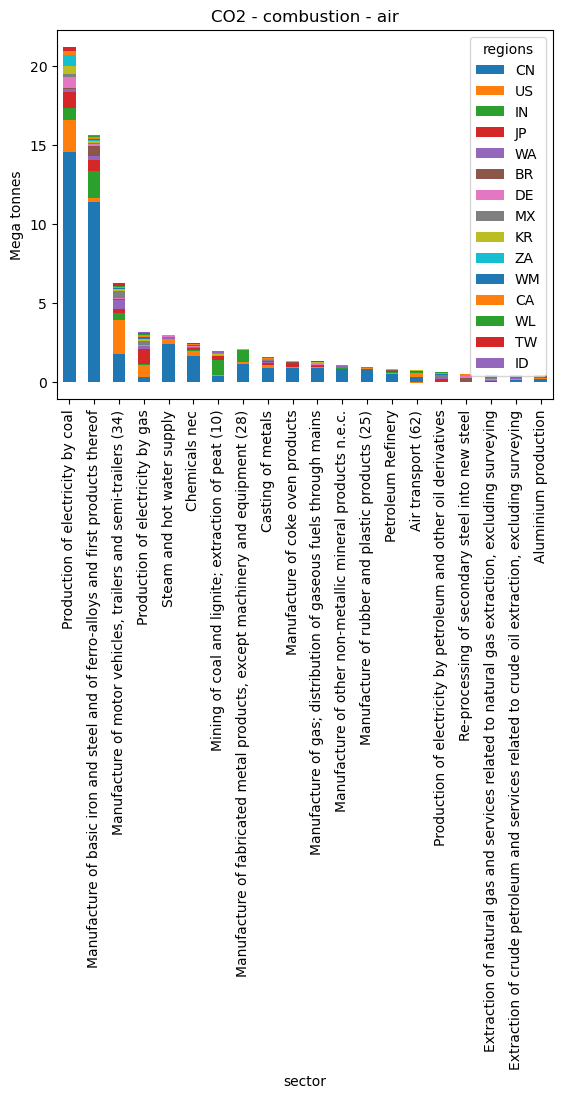

In [21]:
# Plot results
filtered_results.T.plot.bar(stacked=True)
plt.legend(loc='best', ncol=1, title="regions")
plt.title(indicator)
plt.ylabel("Mega tonnes")

## Step 4: Reflect on your scenario, what does your assessment tells you about the sustainability of your circularity interventions? 